In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv("../data/TellusSW_RAD_ALL.csv")

ratio_cols = ['K_Th_ratio', 'Th_U_ratio', 'K_U_ratio']

for col in ratio_cols:
    p1, p99 = np.percentile(features_df[col], [1, 99])
    features_df = features_df[features_df[col].between(p1, p99)]
    
df

k=3: Silhouette=0.405
k=4: Silhouette=0.369
k=5: Silhouette=0.310
k=6: Silhouette=0.373
k=7: Silhouette=0.306
k=8: Silhouette=0.284
k=9: Silhouette=0.233
k=10: Silhouette=0.238


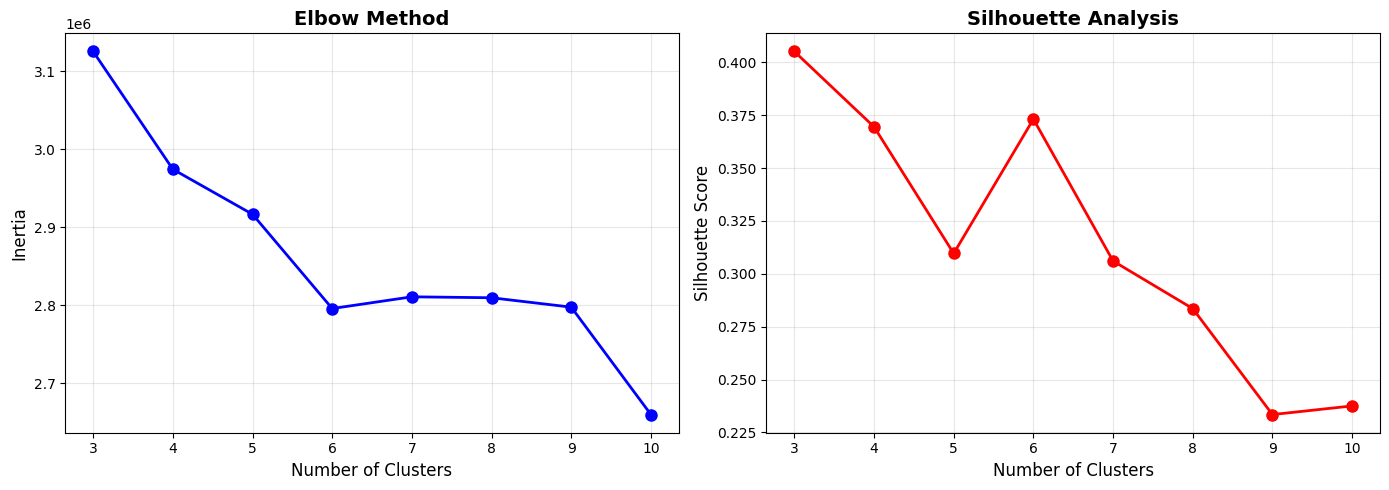

In [29]:
# Doing a k-means clustering on the data


# The ratios of elements could actually contain some really interesting and useful data. For example, uranium gets transported
# in groundwater by dissolving, but thorium doesn't - so the ratio increases in areas of high weathering.
# Similarly it can help determine the types of rock (basalt, granite, clays, etc)

df['K_Th_ratio'] = df['processed_potassium'] / (df['processed_thorium'].abs() + 0.001)
df['Th_U_ratio'] = df['processed_thorium'] / (df['processed_uranium'].abs() + 0.001)
df['K_U_ratio'] = df['processed_potassium'] / (df['processed_uranium'].abs() + 0.001)

# Select features for clustering
feature_cols = ['processed_potassium', 'processed_uranium', 'processed_thorium', 'K_Th_ratio', 'Th_U_ratio', 'K_U_ratio']
features_df = df[feature_cols + ['X_BNG', 'Y_BNG']].copy()

# Rescaling to unit variance and to remove mean
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df[feature_cols])

K_range = range(3, 11)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, 
                             batch_size=10000, n_init=10)
    kmeans.fit(features_scaled)
    labels = kmeans.predict(features_scaled)
    
    inertias.append(kmeans.inertia_)
    sample_idx = np.random.choice(len(features_scaled), 50000, replace=False)
    silhouette_scores.append(silhouette_score(features_scaled[sample_idx], 
                                             labels[sample_idx]))
    print(f"k={k}: Silhouette={silhouette_scores[-1]:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../output/cluster_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
# There's a clear elbow at 6 on the inertia graph, and also a peak on the silhouette analysis graph. So we go with 6!

optimal_k = 6

kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=10000, n_init=10)
clusters = kmeans.fit_predict(features_scaled)
features_df['cluster'] = clusters

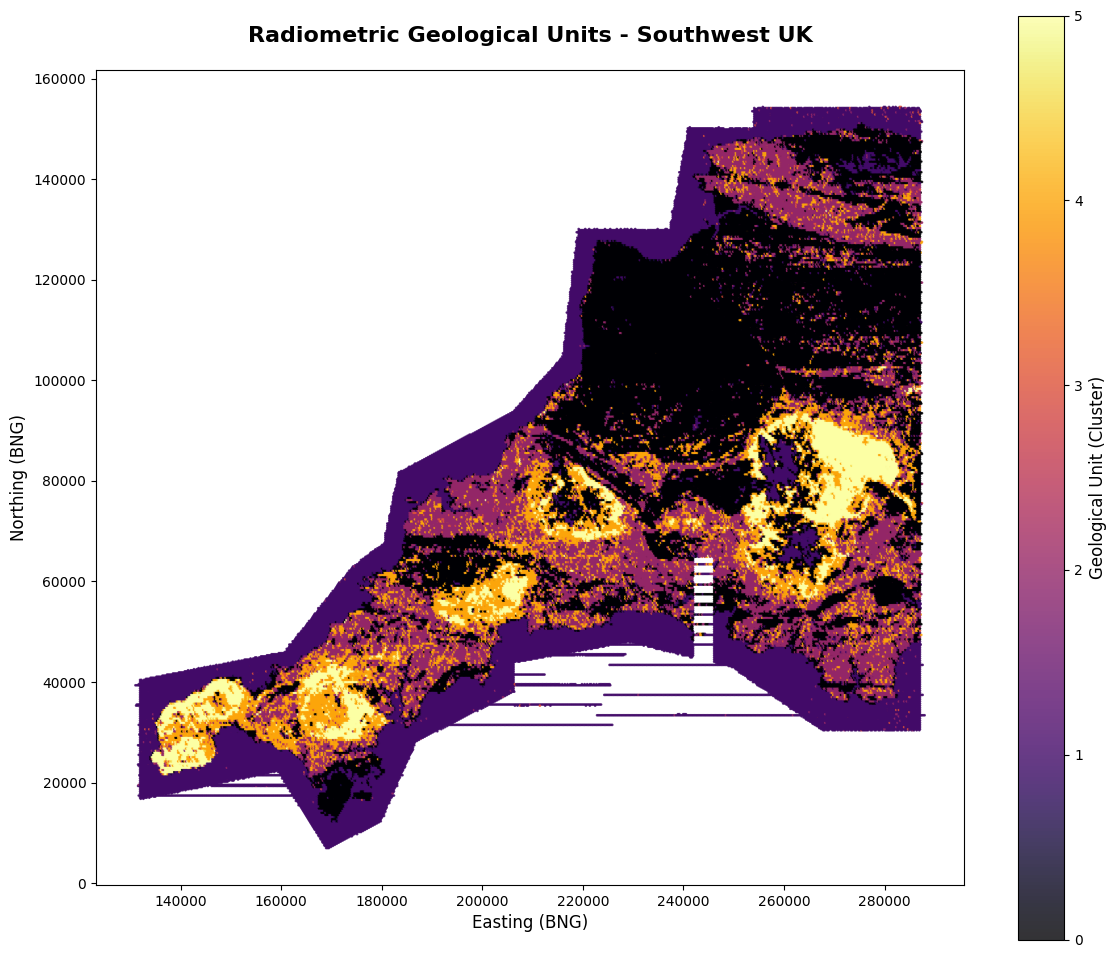

In [32]:
# Draw a map visualizing the spatial clusters;

fig, ax = plt.subplots(figsize=(14, 12))
scatter = ax.hexbin(features_df['X_BNG'], features_df['Y_BNG'],
                    C=features_df['cluster'], 
                    reduce_C_function=lambda x: np.median(x),
                    gridsize=600,
                    cmap='inferno',
                    alpha=0.8)

cbar = plt.colorbar(scatter, ax=ax, label='Geological Unit')
cbar.set_label('Geological Unit (Cluster)', fontsize=12)
ax.set_xlabel('Easting (BNG)', fontsize=12)
ax.set_ylabel('Northing (BNG)', fontsize=12)
ax.set_title('Radiometric Geological Units - Southwest UK', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_aspect('equal', 'box')
plt.savefig('../output/radiometric_clusters_map.png', dpi=300, bbox_inches='tight')
plt.show()

# It seems like the bright yellows overlap with the known granite sites, like on Dartmoor and the Cornubian Batholith.
# The dominant low-radioactivity cluster probably represents sedimentary rocks; the others are harder to tell,
# but probably some combination of minerals and weathered rocks around the granite. Granites are complicated!

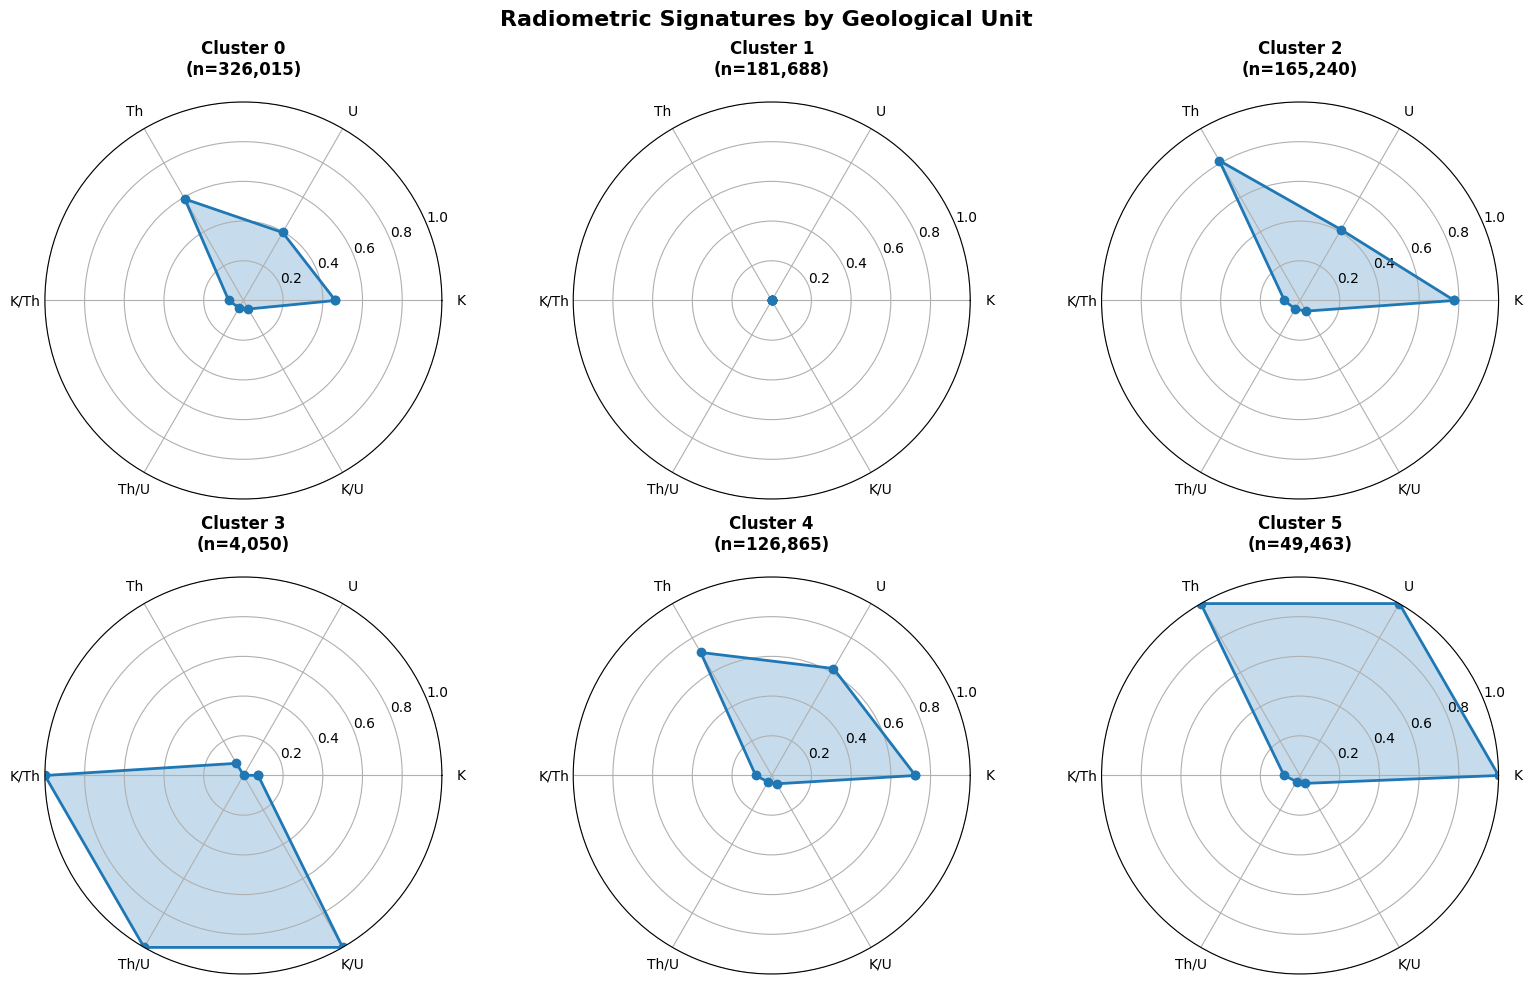

In [33]:
# Visualisation of each of the clusters, for deeper analysis

cluster_means = features_df.groupby('cluster')[feature_cols].mean()
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

fig, axes = plt.subplots(2, 3, figsize=(16, 10), subplot_kw=dict(projection='polar'))
axes = axes.flat

angles = np.linspace(0, 2 * np.pi, len(feature_cols), endpoint=False).tolist()
angles += angles[:1]

for idx, ax in enumerate(axes[:optimal_k]):
    values = cluster_means_norm.iloc[idx].tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {idx}')
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['K', 'U', 'Th', 'K/Th', 'Th/U', 'K/U'], fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_title(f'Cluster {idx}\n(n={sum(clusters==idx):,})', 
                fontsize=12, fontweight='bold', pad=20)
    ax.grid(True)

# Hide unused subplots
for idx in range(optimal_k, len(axes)):
    axes[idx].remove()

plt.suptitle('Radiometric Signatures by Geological Unit', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../output/cluster_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

# These more detailed results lead me to believe;
# Cluster 0 / 3: Sedimentary background (low radioactivity)
# Cluster 1: Ultra-low radioactivity (marine/weathered)
# Cluster 2: High potassium / Thorium (feldspathic rocks)
# Cluster 4: Intermediate rocks (metamorphic/volcanic)
# Cluster 5: Granite intrusions (high K-U-Th)
# Disappointingly there doesn't seem to be much insight into the ratios.

# There's an interesting anomaly - a low radioactivity cluster 1 patch in the middle of the high radioactivity cluster 5 zone of Dartmoor granite.
# This could be because of the large amounts of peat / standing water in the area, blocking the gamma rays.
# (https://naturalengland.blog.gov.uk/2025/05/12/a-new-peat-map-for-england/ shows there's a large depth of peat in the cluster 1 area!)